
Name: Rachel Fanti Coelho Lima    
Date: 12/2021     
Subject: LM-18 73005B - Data Profiling - AY 2021-22    
Task: Implementation of FD.


In [48]:
%matplotlib inline

In [49]:
# pip install PyQt5==5.9.2

In [50]:
import time
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn
import sys

#pip install pandas_profiling --user
#pip install PyQt5==5.9.2
from pandas_profiling import ProfileReport
from pandas_profiling.utils.cache import cache_file

### Input Data 

In [51]:
'''
df = pd.DataFrame([ [ 'C', '3', 'X', 722, 112 ],
                    [ 'A', '1', 'X', 289, 553 ],
                    [ 'A', '1', 'Y', 189, 583 ],
                    [ 'B', '1', 'X', 289, 513 ],
                    [ 'C', '1', 'X', 289, 553 ] ], columns = [a for a in 'abcde'])
'''

"\ndf = pd.DataFrame([ [ 'C', '3', 'X', 722, 112 ],\n                    [ 'A', '1', 'X', 289, 553 ],\n                    [ 'A', '1', 'Y', 189, 583 ],\n                    [ 'B', '1', 'X', 289, 513 ],\n                    [ 'C', '1', 'X', 289, 553 ] ], columns = [a for a in 'abcde'])\n"

In [52]:
df = pd.read_csv('./../00_data/wines2016.csv', sep = ",", index_col=False)
df.columns=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p']
#df.columns = [x for x in range (0, len(df.columns))]

In [53]:
plot_lattice = True

schema = set(a for a in df.columns)

In [54]:
df.head()

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p
0,NaN,NaN,NaN,NaN,Torre Gaia,NaN,NaN,NaN,NaN,Via Boscocupo 11,Dugenta,Benevento,"41.122790, 14.462032",http://www.tenutatorregaia.it/code/home.php,0824 906054,NaN
1,NaN,NaN,NaN,NaN,Terre Stregate,NaN,NaN,NaN,NaN,C.da Santa Lucia SS87,Guardia Sanframondi,Benevento,"41.249499, 14.572098",http://www.terrestregate.it/it/,0824 817857,NaN
2,NaN,NaN,NaN,NaN,Cantine Terranera,NaN,NaN,NaN,NaN,Via Sandro Pertini,Grottolella,Avellino,"40.967256, 14.790662",http://www.cantineterranera.it/terranera/index...,0825 671455,NaN
3,NaN,NaN,NaN,NaN,Santimartini,NaN,NaN,NaN,NaN,"via Bebiana, 107/A",Solopaca,Benevento,"41.194201, 14.528736",http://www.santimartini.it/index.php?lang=it,0824 971254,NaN
4,NaN,NaN,NaN,NaN,Donnachiara,NaN,NaN,NaN,NaN,Via Stazione,Montefalcione,Avellino,"40.955245, 14.878085",http://www.donnachiara.com/,0825 977135,NaN


In [55]:
schema

{'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p'}

### Layout functions

In [56]:
def layout_lattice(basket):
    from itertools import combinations
    from scipy.special import binom
    G = nx.DiGraph()
    len_max, pos = binom(len(basket), len(basket)/2), {}
    for k in range(1, len(basket)+1):
        sorted_nodes_at_level = sort([set(e) for e in combinations(basket, k)])
        G.add_nodes_from(sorted_nodes_at_level)
        for p, n in enumerate(sorted_nodes_at_level):
            pos[n] = (p + 0.5 * (len_max - len(sorted_nodes_at_level)), k-len(basket))
        nx.draw_networkx_nodes(G, pos, nodelist=sorted_nodes_at_level, node_color='tab:grey')
        
    return G, pos

In [57]:
def mark_as_visited_sup(E, F):
    if not plot_lattice: return
    nx.draw_networkx_nodes(viz[0], viz[1], nodelist=sort(E), node_color='tab:red')
    nx.draw_networkx_nodes(viz[0], viz[1], nodelist=sort(F), node_color='tab:green')
    nx.draw_networkx_labels(viz[0], viz[1], font_size=8, font_color="whitesmoke")
    plt.show()
    plt.pause(1)

def mark_as_visited_gen(f, s):
    if not plot_lattice: return
    edges = [(sort_single(f), sort_single(s))]
    viz[0].add_edges_from(edges)
    nx.draw_networkx_edges(viz[0], viz[1], edgelist=edges, arrows=False)

### Helper functions

In [58]:
def sort_single(s):
    return ''.join(sorted(list(s)))

def sort(F):
    return sorted(sort_single(s) for s in F)

In [59]:
# original to keep
def pli_single(a, D):
    pli = {}
    for row in range(D.shape[0]):
        key = D.at[row, a]
        if key in pli:
            pli[key].add(row)
        else:
            pli[key] = { row }
    return list(v for v in pli.values() if len(v) > 1)

In [60]:
# original to keep
def pli_intersect(p1, p2):
    pli, prob = {}, {}
    for c, s in enumerate(p1):
        for row in s:
            prob[row] = c
    for c, s in enumerate(p2):
        for row in s:
            if row in prob:
                key = (c, prob[row])
                if key in pli:
                    pli[key].add(row)
                else:
                    pli[key] = { row }
            
    return list(v for v in pli.values() if len(v) > 1)

In [61]:
def intersection_sets (set_1, set_2):
    
    '''Finding the common chars for both strings
        
    '''
    result = set() 
    for e in set_1:
        if e in set_2:
            result.add(e)
    return result

In [62]:
#rachel
def set_intersect(X, C):
    
    '''
    e.g.
    Input:
    X = {'b', 'a'}
    C = {'d': {'a', 'b', 'c', 'd', 'e'}, 'e': {'a', 'b', 'c', 'd', 'e'}, 'b': {'a', 'b', 'c'}, 'c': {'a', 'b', 'c', 'd', 'e'}, 'a': {'a', 'c', 'e'}}
    set_intersect(X, C)
    
    Output:
    {'ab': {'a', c'}}
    
    '''
    intersection = {} 
    X = sort_single(X)
    for key, value in C.items():
        if all (k in X for k in key):
            if X in intersection:
                intersection[X]= intersection_sets (intersection[X], value)
            else:
                intersection[X] = value
    return intersection

In [63]:
#rachel 
def get_cardinality (list_of_sets):
    '''calculates the cardinality of a list of sets
    
    e.g. 
    
    Input   
    list_of_sets = [{0, 4}, {1, 2}]
    get_cardinality (list_of_sets)
    
    Output
    4
    '''
    count = 0
    for s in list_of_sets: #for each set in list of sets
        for e in s: # for each element in set
            count += 1
    return count

In [64]:
#rachel
def is_valid(X, A, pli):
    ''' X\A->A - Check if is a funtional dependency
    Use key-error and pli to infer FDs (key error can be used with pli and stripped-pli): 
    X->y
    pli(X)=pli(XY)
    cr(X)=Cr(XY) 
               
    Therefore:
    X\A->A 
    Cr(X\A) = Cr(X)    
    
    e.g.
    
    Input:
    X = {'b', 'd'}
    A = 'b'
    pli = {'d': [{1, 3, 4}], 'e': [{1, 4}], 'b': [{1, 2, 3, 4}], 'c': [{0, 1, 3, 4}], 'a': [{0, 4}, {1, 2}], 'ab': [{1, 2}], 'ac': [{0, 4}], 'ad': [], 'ae': [], 'bc': [{1, 3, 4}], 'bd': [{1, 3, 4}], 'be': [{1, 4}], 'cd': [{1, 3, 4}], 'ce': [{1, 4}], 'de': [{1, 4}]}
    is_valid(X, A, pli)
    
    Output:
    True
    '''

    pli_X_wth_A = pli[sort_single(X).replace(A, '')]
    key_error_X_wth_A = get_cardinality(pli_X_wth_A) - len(pli_X_wth_A) 
    
    pli_X = pli[sort_single(X)]
    key_error_X = get_cardinality(pli_X) - len(pli_X)
    
    if  key_error_X_wth_A == key_error_X:
        return True
    else:
        return False

In [65]:
#rachel
def is_key(X, pli):
    ''' Check if X is a (super)key 
        verify if key_error_X = 0
    
    '''   
    pli_X = pli[sort_single(X)]
    key_error_X = get_cardinality(pli_X) - len(pli_X)
    
    if  key_error_X == 0:
        return True
    else:
        return False

### Funtional dependency discovery algorithm

In [66]:
#rachel
def apriori_fd_discovery(schema, table):
    '''
    Ej: candidates LHSs [of size j?]
    Fj: validated LHSs [of size j?]
    Cj: candidates RHSs for LHSs [of size j?]
    
    Format: 
    E: [{'c', 'b', 'a'}, {'d', 'c', 'b'}, {'e', 'c', 'b'}, {'d', 'b', 'e'}, {'d', 'c', 'e'}]
    pli: {'ad': [], 'ae': [], 'abc': [], 'bcd': [{1, 3, 4}], 'bce': [{1, 4}], 'bde': [{1, 4}], 'cde': [{1, 4}]}
    C = {'d': {'a', 'b', 'c', 'd', 'e'}, 'e': {'a', 'b', 'c', 'd', 'e'}, 'b': {'a', 'b', 'c', 'd', 'e'}, 'c': {'a', 'b', 'c', 'd', 'e'}, 'a': {'a', 'b', 'c', 'd', 'e'}} 
       
    '''
    k=1
    U = []
    E, pli = [set(a) for a in schema], {a: pli_single(a, table) for a in schema} # single attribute sets and PLIs
    C = {sort_single(a): schema for a in schema} # canidates sets for single attributes
    F, U = prune(E, pli, C) # determine the non-unique ones 
    # print('\n','E:', E, '\n', 'pli:', pli, '\n', 'C:', C, '\n', 'F:', F)
    while len(F)!=0: # while there are non-dependent LHSs 
        E, pli_next = candidates(F, pli) # create candidate LHSs with one attribute more and PLIs
        pli.update(pli_next)
        C, U_next_1 = dependencies (E, pli, C) # create candidate RHSs for new candidate LHSs
        # print('\n','E:', E, '\n', 'pli:', pli, '\n', 'C:', C)
        F, U_next_2 = prune(E, pli, C) # and determine the non-dependent LHSs
                              # increment again the LHSs size 
        U = U + U_next_1 + U_next_2
        U = sorted(U, key = lambda i: (len(i[0]), i[0]))
        # print('\n', 'U:', U)
        # print('\n', 'F:', F)
        print('--> done with level', k, ' - FDs: ', end ="")
        print(['%s -> %s' % (sort_single(set(u[0])),u[1]) for u in U if len(u[0]) == k]),
        k=k+1
    return U # return the functional dependencies

In [67]:
# original to keep
def candidates(F, pli):
    '''   
    Format:
    E: [{'b', 'a'}, {'c', 'a'}, {'d', 'a'}, {'e', 'a'}, {'c', 'b'}]
    pli: {'c': [{0, 1, 3, 4}], 'e': [{1, 4}], 'b': [{1, 2, 3, 4}], 'd': [{1, 3, 4}], 'ab': [{1, 2}], 'ac': [{0, 4}], 'ad': [], 'ae': [], 'bc': [{1, 3, 4}]}
    
    '''    
    pli_next = pli.copy()
    Fs, E_next = sort(F), []
    for i1 in range(len(Fs)):
        for i2 in range(i1+1, len(Fs)):
            if Fs[i1][:-1] == Fs[i2][:-1] and Fs[i1][-1] < Fs[i2][-1]:
                f = set(fs for fs in Fs[i1]).union({Fs[i2][-1]})
                superset = len(f)
                for i in f:
                    if f.difference({i}) in F:
                        superset -= 1
                if not superset:
                    E_next.append(f)
                    pli_next[sort_single(f)] = pli_intersect(pli_next[sort_single(Fs[i1])],
                                                        pli_next[sort_single(Fs[i2])])
                    mark_as_visited_gen(f, set(s for s in Fs[i1]))
        del pli[sort_single(Fs[i1])]
    return E_next, pli_next

In [68]:
#rachel
def dependencies(E, pli, C): 
    '''
    INPUTs:
    E = [{'b', 'a'}, {'c', 'a'}, {'d', 'a'}, {'e', 'a'}, {'c', 'b'}, {'d', 'b'}, {'e', 'b'}, {'d', 'c'}, {'c', 'e'}, {'d', 'e'}] 
    pli = {'d': [{1, 3, 4}], 'e': [{1, 4}], 'b': [{1, 2, 3, 4}], 'c': [{0, 1, 3, 4}], 'a': [{0, 4}, {1, 2}], 'ab': [{1, 2}], 'ac': [{0, 4}], 'ad': [], 'ae': [], 'bc': [{1, 3, 4}], 'bd': [{1, 3, 4}], 'be': [{1, 4}], 'cd': [{1, 3, 4}], 'ce': [{1, 4}], 'de': [{1, 4}]} 
    C = {'d': {'a', 'b', 'c', 'd', 'e'}, 'e': {'a', 'b', 'c', 'd', 'e'}, 'b': {'a', 'b', 'c', 'd', 'e'}, 'c': {'a', 'b', 'c', 'd', 'e'}, 'a': {'a', 'b', 'c', 'd', 'e'}} 
    dependencies(E, pli, C)
 
    E.g.
    LHS = left hand size = X = {'b', 'c', 'e'}
    RHS = right hand size = X-A = {'c', 'e'}
    A = {'b'}
    '''

    Cd  = {} # initialize the set of rhs candidates
    U = []
    for X in E: # traverse the lhs candidates
        rhs = set_intersect(X, C) # Add rhs candidates from previous level
        Cd.update(rhs)
    for X in E: # traverse the lhs candidates (change for x, pli!!)
        for A in sort_single(X):
            if A in Cd[sort_single(X)]: # traverse the rhs candidates
                if is_valid (X, A, pli): # check if valid using key error and pli
                    # print ('***FD***', X,'/',A, '-->', A) # then is a minimal funtional dependency                                [C1]
                    U_A = [x for x in X if x != A] # U-A
                    U.append((sort(U_A), A))
                    Cd[sort_single(X)] = Cd[sort_single(X)]-{A} # remove from RHS candidates [C1]
                    # print ('C1 - C[', X, ']:', Cd[sort_single(X)])
                    for B in (schema-X): # traverse the candidates
                        Cd[sort_single(X)] = Cd[sort_single(X)]-{B} # remove from RHS candidates [C2]
                    # print ('C2 - C[', X, ']:', Cd[sort_single(X)])
    return Cd, U #return the pruned RHS candidates sets and the funtional dependencies

In [69]:
#rachel
def prune(E, pli, C):  
    '''
    Formats:
    E = [{'b', 'a'}, {'c', 'a'}, {'d', 'a'}, {'e', 'a'}, {'c', 'b'}, {'d', 'b'}, {'e', 'b'}, {'d', 'c'}, {'c', 'e'}, {'d', 'e'}] 
    pli = {'a': [{0, 4}, {1, 2}], 'c': [{0, 1, 3, 4}], 'd': [{1, 3, 4}], 'b': [{1, 2, 3, 4}], 'e': [{1, 4}], 'ad': [], 'ae': [], 'ab': [{1, 2}], 'ac': [{0, 4}], 'bc': [{1, 3, 4}], 'bd': [{1, 3, 4}], 'be': [{1, 4}], 'cd': [{1, 3, 4}], 'ce': [{1, 4}], 'de': [{1, 4}], 'abc': [], 'bcd': [{1, 3, 4}], 'bce': [{1, 4}], 'bde': [{1, 4}], 'cde': [{1, 4}]}

    C = {'ab': {'a', 'b', 'c', 'd', 'e'}, 'ac': {'a', 'b', 'c', 'd', 'e'}, 'ad': {'a', 'b', 'c', 'd', 'e'}, 'ae': {'a', 'b', 'c', 'd', 'e'}, 'bc': '{'a', 'b', 'c', 'd', 'e'}, 'bd': {'d'}, 'be': {'e'}, 'cd': {'d'}, 'ce': {'e'}, 'de': {'e'}}
    X = {'d', 'a'}
    U = []
    '''
    U=[]
    F = E.copy() # initialize the set of LHSs candidates
    for X in E: # traverse the candidates
        if len(C[sort_single(X)])==0: # if a LHS there is no RHS candidate
            F.remove(X) # remove the LHS form the prefix tree
        if is_key(X, pli): # check if is a (super)key using key-error and pli
            print (sort_single(X) ,'is key')
            for A in ([x for x in C[sort_single(X)] if x not in sort_single(X)]): # traverse the RHSs candidates of X [and iterate in each candidate C[X] - X
                keys_XA_B = [sort_single(X.union(A)).replace(B,"") for B in sort_single(X)] #C[X+A-B] if RHS in all C of augmented LHS subsets [C3]
                # print ('keys_XA_B', keys_XA_B)  
                if all (key in C for key in keys_XA_B): # [Check if exist all augmented LHS subsets]
                    # print ('all keys present')
                    if all(A in C[k] for k in keys_XA_B): #if RHS in all C of augmented LHS subsets [C3]
                        # print ('***FD***', sort_single(X), "-->", A, 'Minimal') # then it is a minimal FD
                        U.append((sort(list(X)), A))
            F.remove(X) # remove the LHS from the prefix tree (everything after this will not be minimal) [key-pruning]  
    mark_as_visited_sup(E, F)
    return F, U # return the pruned set of candidates and the funtional dependencies

### Run

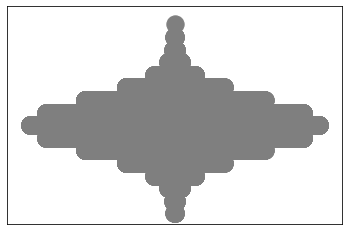

In [72]:
if plot_lattice:
    viz = layout_lattice(schema)
    plt.ion()

     a    b    c    d                  e    f    g    h    i  \
0  NaN  NaN  NaN  NaN         Torre Gaia  NaN  NaN  NaN  NaN   
1  NaN  NaN  NaN  NaN     Terre Stregate  NaN  NaN  NaN  NaN   
2  NaN  NaN  NaN  NaN  Cantine Terranera  NaN  NaN  NaN  NaN   
3  NaN  NaN  NaN  NaN       Santimartini  NaN  NaN  NaN  NaN   
4  NaN  NaN  NaN  NaN        Donnachiara  NaN  NaN  NaN  NaN   

                       j                    k          l  \
0       Via Boscocupo 11              Dugenta  Benevento   
1  C.da Santa Lucia SS87  Guardia Sanframondi  Benevento   
2     Via Sandro Pertini          Grottolella   Avellino   
3     via Bebiana, 107/A             Solopaca  Benevento   
4           Via Stazione        Montefalcione   Avellino   

                      m                                                  n  \
0  41.122790, 14.462032        http://www.tenutatorregaia.it/code/home.php   
1  41.249499, 14.572098                    http://www.terrestregate.it/it/   
2  40.967256, 14.790

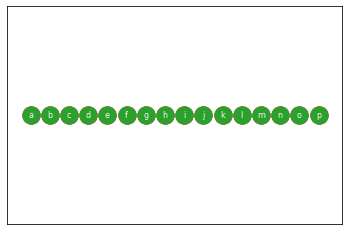

ae is key
aj is key


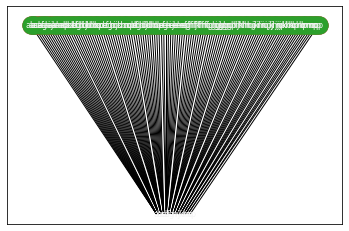

--> done with level 1  - FDs: ['a -> c', 'a -> d', 'e -> m', 'e -> p', 'j -> k', 'j -> m', 'j -> o', 'j -> p', 'k -> p', 'm -> p', 'o -> p']
akm is key
akn is key
ako is key
aln is key
alo is key
amn is key
amo is key
ano is key


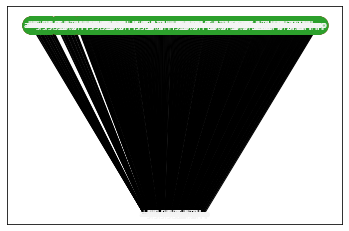

--> done with level 2  - FDs: ['ae -> l', 'ae -> k', 'ae -> b', 'ae -> f', 'ae -> j', 'ae -> g', 'ae -> h', 'ae -> n', 'ae -> i', 'ae -> o', 'af -> b', 'af -> g', 'af -> i', 'aj -> e', 'aj -> l', 'aj -> b', 'aj -> f', 'aj -> g', 'aj -> h', 'aj -> n', 'aj -> i', 'ak -> b', 'ak -> f', 'ak -> g', 'ak -> h', 'ak -> i', 'ak -> l', 'am -> b', 'am -> f', 'am -> g', 'am -> h', 'am -> i', 'am -> l', 'an -> b', 'an -> f', 'an -> g', 'an -> h', 'an -> i', 'ao -> b', 'ao -> f', 'ao -> g', 'ao -> h', 'ao -> i', 'be -> j', 'be -> k', 'be -> o', 'ef -> j', 'ef -> k', 'ef -> l', 'ef -> n', 'ef -> o', 'ek -> j', 'ek -> o', 'el -> j', 'el -> k', 'el -> o', 'en -> j', 'en -> k', 'en -> o', 'eo -> j', 'eo -> k', 'fj -> l', 'fj -> n', 'fk -> l', 'fm -> l', 'gj -> l', 'gj -> n', 'gk -> l', 'km -> j', 'km -> o', 'kn -> j', 'kn -> m', 'kn -> o', 'ko -> j', 'ko -> m', 'ln -> p', 'mn -> j', 'mn -> k', 'mn -> o', 'mo -> j', 'mo -> k', 'no -> j', 'no -> k', 'no -> m']


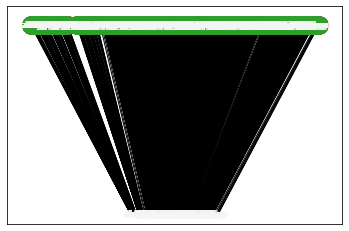

--> done with level 3  - FDs: ['agh -> i', 'akm -> n', 'ako -> n', 'aln -> m', 'aln -> k', 'aln -> o', 'alo -> m', 'alo -> k', 'alo -> n', 'amo -> n', 'ano -> l', 'bce -> l', 'bcj -> l', 'bck -> l', 'bcm -> l', 'bde -> l', 'bdj -> l', 'bdk -> l', 'bdm -> l', 'bef -> i', 'beg -> l', 'beg -> n', 'bfh -> i', 'bfj -> e', 'bfj -> i', 'bfk -> i', 'bfm -> i', 'bfn -> i', 'bfo -> i', 'bgm -> l', 'bln -> j', 'bln -> k', 'bln -> m', 'bln -> o', 'blo -> j', 'blo -> k', 'blo -> m', 'cij -> l', 'cik -> l', 'cln -> j', 'cln -> k', 'cln -> m', 'cln -> o', 'clo -> j', 'clo -> k', 'clo -> m', 'def -> i', 'dei -> j', 'dei -> k', 'dei -> l', 'dei -> o', 'dfj -> i', 'dfk -> i', 'dfm -> i', 'dfn -> i', 'dfo -> i', 'dij -> l', 'dik -> l', 'dim -> l', 'dlo -> j', 'dlo -> k', 'dlo -> m', 'egi -> j', 'egi -> k', 'egi -> l', 'egi -> n', 'egi -> o', 'egk -> n', 'egl -> n', 'egn -> l', 'ego -> l', 'ego -> n', 'fkm -> n', 'fko -> n', 'fln -> j', 'fln -> k', 'fln -> m', 'fln -> o', 'flo -> j', 'flo -> k', 'flo -> m

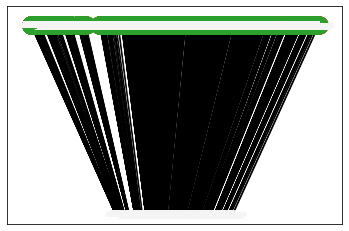

--> done with level 4  - FDs: ['bcno -> l', 'bdfh -> g', 'bdno -> l', 'bfgh -> d', 'bfkm -> e', 'bfkn -> e', 'bfko -> e', 'bfln -> e', 'bflo -> e', 'bfmn -> e', 'bfmo -> e', 'bfno -> e', 'cein -> l', 'ceio -> l', 'cimn -> l', 'cimo -> l', 'cino -> l', 'defh -> g', 'dfhi -> g', 'dfhj -> g', 'dfhk -> g', 'dfhm -> g', 'dfhn -> g', 'dfho -> g', 'dino -> l', 'efgh -> i', 'fghj -> i', 'fghk -> i', 'fghm -> i', 'fghn -> i', 'fgho -> i']


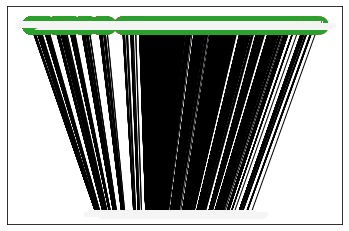

--> done with level 5  - FDs: ['bcdeh -> i', 'bcdhj -> i', 'bcdhm -> i', 'bcdhn -> i', 'bcdho -> i', 'bcegh -> i', 'bcghj -> i', 'bcghm -> i', 'bcghn -> i', 'bcgho -> i', 'cdfgh -> i', 'cdfhl -> g', 'cdfhl -> i', 'cefgh -> d', 'cfghi -> d', 'cfghj -> d', 'cfghk -> d', 'cfghl -> d', 'cfghl -> i', 'cfghm -> d', 'cfghn -> d', 'cfgho -> d']


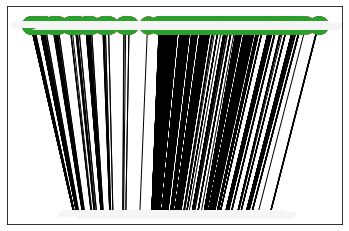

--> done with level 6  - FDs: []


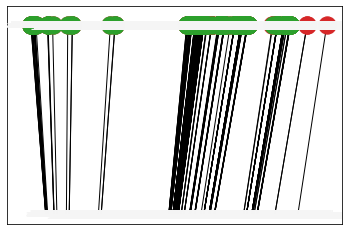

--> done with level 7  - FDs: []


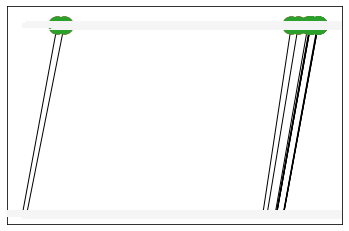

--> done with level 8  - FDs: []


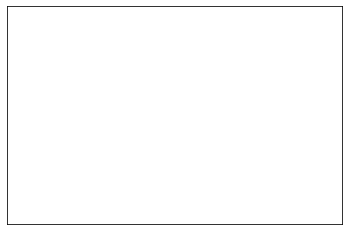

--> done with level 9  - FDs: []


discovered 258 minimal FDs in 1633.10187292099  seconds

***All FDs:
['a -> c', 'a -> d', 'e -> m', 'e -> p', 'j -> k', 'j -> m', 'j -> o', 'j -> p', 'k -> p', 'm -> p', 'o -> p', 'ae -> l', 'ae -> k', 'ae -> b', 'ae -> f', 'ae -> j', 'ae -> g', 'ae -> h', 'ae -> n', 'ae -> i', 'ae -> o', 'af -> b', 'af -> g', 'af -> i', 'aj -> e', 'aj -> l', 'aj -> b', 'aj -> f', 'aj -> g', 'aj -> h', 'aj -> n', 'aj -> i', 'ak -> b', 'ak -> f', 'ak -> g', 'ak -> h', 'ak -> i', 'ak -> l', 'am -> b', 'am -> f', 'am -> g', 'am -> h', 'am -> i', 'am -> l', 'an -> b', 'an -> f', 'an -> g', 'an -> h', 'an -> i', 'ao -> b', 'ao -> f', 'ao -> g', 'ao -> h', 'ao -> i', 'be -> j', 'be -> k', 'be -> o', 'ef -> j', 'ef -> k', 'ef -> l', 'ef -> n', 'ef -> o', 'ek -> j', 'ek -> o', 'el -> j', 'el -> k', 'el -> o', 'en -> j', 'en -> k', 'en -> o', 'eo -> j', 'eo -> k', 'fj -> l', 'fj -> n', 'fk -> l', 'fm -> l', 'gj -> l', 'gj -> n', 'gk -> l', 'km -> j', 'km -> o', 'kn -> j', 'kn 

In [73]:
# run it
print(df.head())
print('')
print('Funtional dependency discovery on', sort_single(schema))

'''
profile = ProfileReport(table, title="dataset", explorative=True)
profile.to_file("./report.html")
'''

fd_start = time.time()
fd = apriori_fd_discovery(schema, df)

# print it
print('\n\ndiscovered', len(fd), 'minimal FDs in', time.time() - fd_start, ' seconds')
print('\n***All FDs:')
print(['%s -> %s' % (sort_single(set(u[0])),u[1]) for u in fd]),

if plot_lattice:    
    plt.ioff()
    plt.show()